### ***基于Kmeans/DBSCAN/GMM聚类方法以及DT/KNN/NB/RF分类方法的高光谱遥感图像的分析***

### **@2021010724王晨  指导老师：张小咏**

In [81]:
import scipy.io as scio
import matplotlib.pyplot as plt
import numpy as np
import random
import spectral as spy
from sklearn import preprocessing, metrics
import torch
import torch.nn.functional as F
from scipy.linalg import eigh
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier

#### **导入数据集并且划分训练集测试集（分类用）**

In [89]:
datasetname = 'BW'
if datasetname == 'PU':
    datafile = 'PaviaU.mat'
    datafile_ = 'paviaU'
    labelfile = 'PaviaU_gt.mat'
    labelfile_ = 'paviaU_gt'
elif datasetname == 'SA':
    datafile = 'SalinasA_corrected.mat'
    datafile_ = 'salinasA_corrected'
    labelfile = 'SalinasA_gt.mat'
    labelfile_ = 'salinasA_gt'
elif datasetname == 'BW':
    datafile = 'Botswana.mat'
    datafile_ = 'Botswana'
    labelfile = 'Botswana_gt.mat'
    labelfile_ = 'Botswana_gt'
elif datasetname == 'PaviaCenter':
    datafile = 'Pavia.mat'
    datafile_ = 'pavia'
    labelfile = 'Pavia_gt.mat'
    labelfile_ = 'pavia_gt'
    
data = scio.loadmat(datafile).get(datafile_)
label = scio.loadmat(labelfile).get(labelfile_)
H, W, C = data.shape
print(f'Dataset name: {datasetname}, shape: {data.shape}, ground truth shape: {label.shape}')

Dataset name: BW, shape: (1476, 256, 145), ground truth shape: (1476, 256)


#### **数据min-max归一化及PCA去除冗余（分类用）**

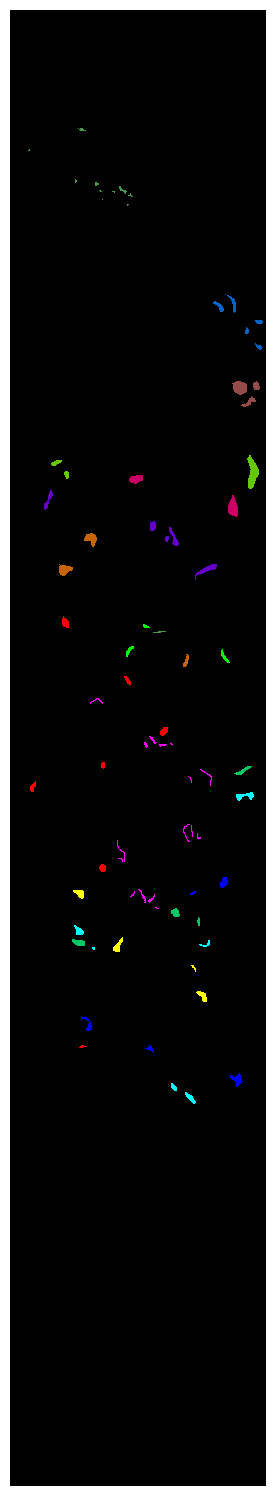

In [90]:
def Draw_Classification_Map(datasetname,label, name: str, scale: float = 4.0, dpi: int = 400):
    fig, ax = plt.subplots()
    numlabel = np.array(label)
    v = spy.imshow(classes=numlabel.astype(np.int16), fignum=fig.number)
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.set_size_inches(label.shape[1] * scale / dpi, label.shape[0] * scale / dpi)
    foo_fig = plt.gcf() 
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    foo_fig.savefig(datasetname +' '+ name + '.png', format='png', transparent=True, dpi=dpi, pad_inches=0)
    pass
def evaluate_performance(output, label, require_AA_KPP=False, printFlag=True):
    label = torch.tensor(label)
    if not require_AA_KPP:
        with torch.no_grad():
            pred = torch.tensor(output)
            correct = float(pred.eq(label).sum().item())
            OA = correct/ (label !=255).float().sum()
            return OA
    else:
        with torch.no_grad():
            # OA
            pred = torch.tensor(output)
            correct = float(pred.eq(label).sum().item())
            OA = correct / (label != 255).float().sum()
            OA = OA.cpu().numpy()
            y_pred = pred.cpu().numpy()
            gt_label = label.cpu().numpy()
            # Kappa
            kappa = metrics.cohen_kappa_score(y_pred, gt_label)
            # confusion_matrix
            confusion_matrix = metrics.confusion_matrix(gt_label, y_pred)
            producer_acc = np.diag(confusion_matrix)/np.sum(confusion_matrix,axis=1)
            AA = np.average(producer_acc)

            print("test OA=", OA, 'test AA=', AA,'kpp=', kappa, 'confusion matrix=\n', confusion_matrix)
            pass
data = np.reshape(data,[H*W,C])#展成二维
minMax = preprocessing.StandardScaler()
data = minMax.fit_transform(data)
label = np.reshape(label,[H*W])#展成二维
pca = PCA(n_components=0.99)
data_clear = pca.fit_transform(data)

gt_map = np.reshape(label,[H,W])
Draw_Classification_Map(datasetname,gt_map,'ground truth')


#### **划分训练集和测试集（分类用）**

Training Size = 1948, Testing Size = 1300
========================== Random Forest evaluation==========================
test OA= 0.92846155 test AA= 0.9372349637491835 kpp= 0.9225002483966398 confusion matrix=
 [[106   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  45   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0   0 103   0   0   0   0   1   1   1   0   0   0   0]
 [  0   0   0  86   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   3  98   7   0   0   0   0   0   0   0   0]
 [  0   0   0   0  12  70   0   0   6   0   0   0   0   0]
 [  0   1   0   1   0   0 101   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  72   0   0   0   0   0   0]
 [  0   0   0   1   0  19   0   0 112   0   0   0   2   0]
 [  0   0   0   0   0   0   0   1   0  95   7   0   0   0]
 [  0   0   0   0   0   0   0   1   0  11 111   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  72   4   0]
 [  0   0   0   0   0   0   0   0   2   2   1   4 102   2]
 [  0   0   0   0   0 

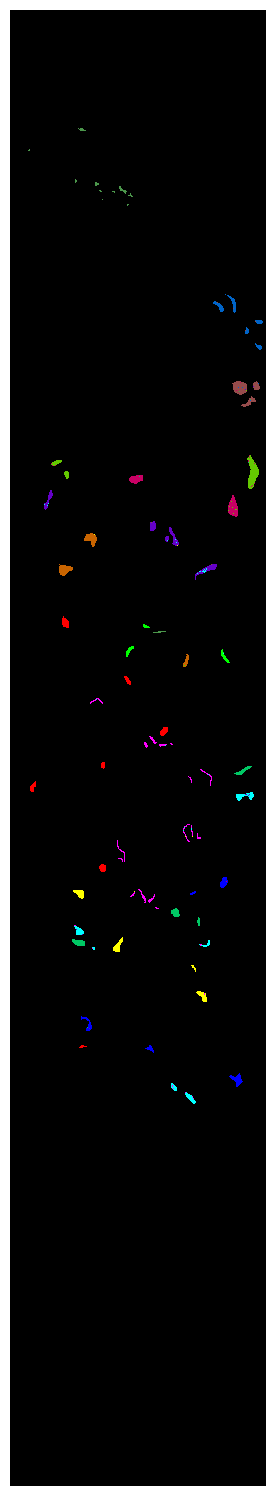

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


non_zero_indices = label != 0
data_non_zero = data_clear[non_zero_indices]
label_non_zero = label[non_zero_indices]
X_train, X_test, y_train, y_test = train_test_split(data_non_zero, label_non_zero, test_size=0.4, random_state=42)
print(f'Training Size = {X_train.shape[0]}, Testing Size = {X_test.shape[0]}')

# 决策树
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
RF_predictions = RF.predict(X_test)
print("========================== Random Forest evaluation==========================")
evaluate_performance(RF_predictions,y_test,require_AA_KPP=True)

# 将决策树预测结果可视化
RF_pred_map = np.zeros_like(label)
RF_pred_map[non_zero_indices] = RF.predict(data_clear[non_zero_indices])
pred_map4 = np.reshape(RF_pred_map, [H, W])

Draw_Classification_Map(datasetname,pred_map4, 'random forests')

# # 朴素贝叶斯
# nb = GaussianNB()
# nb.fit(X_train, y_train)
# nb_predictions = nb.predict(X_test)
# print("==========================Naive Bayes evaluation==========================")
# evaluate_performance(nb_predictions,y_test,require_AA_KPP=True)

# # 将朴素贝叶斯预测结果可视化
# nb_pred_map = np.zeros_like(label)
# nb_pred_map[non_zero_indices] = nb.predict(data_clear[non_zero_indices])
# pred_map2 = np.reshape(nb_pred_map, [H, W])

# Draw_Classification_Map(datasetname,pred_map2, 'Naive Bayes prediction')

# # K邻近
# knn = KNeighborsClassifier()
# knn.fit(X_train,y_train)
# knn_predictions = knn.predict(X_test)
# print("==========================K nearst neighbors evaluation==========================")
# evaluate_performance(knn_predictions, y_test,require_AA_KPP=True)

# knn_pred_map = np.zeros_like(label)
# knn_pred_map[non_zero_indices] = knn.predict(data_clear[non_zero_indices])
# pred_map3 = np.reshape(knn_pred_map, [H, W])

# Draw_Classification_Map(datasetname,pred_map3, 'K nearst neighbors')

#### **显示高光谱图像**

In [ ]:
import scipy.io as sio
import spectral
import numpy as np
import wx

vv=data
app = wx.App()
spectral.settings.WX_GL_DEPTH_SIZE=16
spectral.view_cube(vv, bands=[60,18,20])
app.MainLoop()


Mouse Functions:
----------------
left-click & drag        ->   Rotate cube
CTRL+left-click & drag   ->   Zoom in/out
SHIFT+left-click & drag  ->  Pan

Keybinds:
---------
l       -> toggle light
t/g     -> stretch/compress z-dimension
h       -> print help message
q       -> close window



0

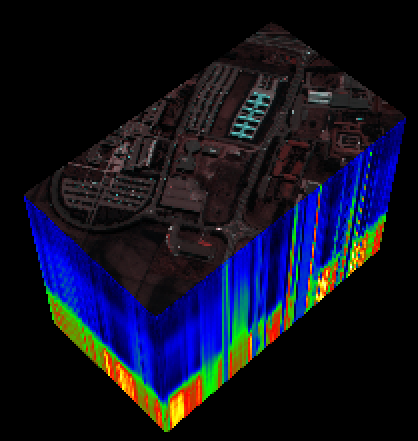

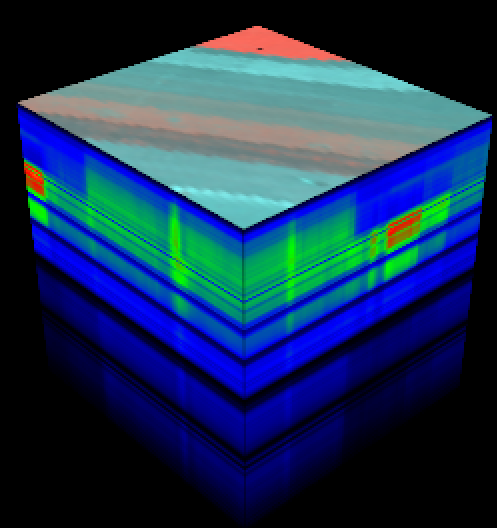

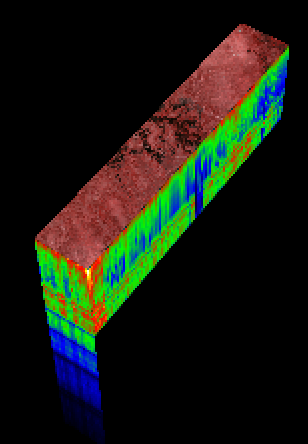

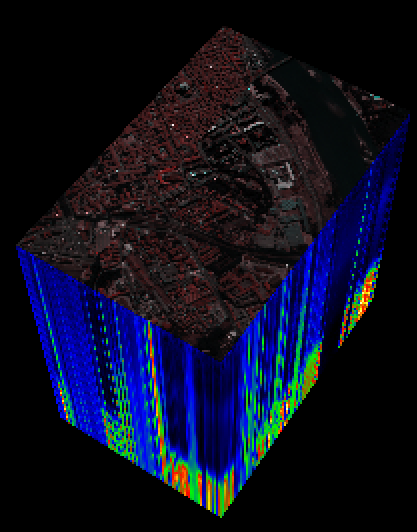

#### **无监督聚类（不使用LabelFile）**

In [104]:
datasetname = 'BW'
if datasetname == 'PU':
    datafile = 'PaviaU.mat'
    datafile_ = 'paviaU'
    labelfile = 'PaviaU_gt.mat'
    labelfile_ = 'paviaU_gt'
elif datasetname == 'SA':
    datafile = 'SalinasA_corrected.mat'
    datafile_ = 'salinasA_corrected'
    labelfile = 'SalinasA_gt.mat'
    labelfile_ = 'salinasA_gt'
elif datasetname == 'BW':
    datafile = 'Botswana.mat'
    datafile_ = 'Botswana'
    labelfile = 'Botswana_gt.mat'
    labelfile_ = 'Botswana_gt'
elif datasetname == 'PaviaCenter':
    datafile = 'Pavia.mat'
    datafile_ = 'pavia'
    labelfile = 'Pavia_gt.mat'
    labelfile_ = 'pavia_gt'
    
data = scio.loadmat(datafile).get(datafile_)
H, W, C = data.shape
print(f'Dataset name: {datasetname}, Height : {H}, Weight: {W}, Channel: {C}')
data = np.reshape(data,[H*W,C])#展成二维
label = scio.loadmat(labelfile).get(labelfile_)#原始数据的类别数，与肘部法进行对比
minMax = preprocessing.StandardScaler()
data = minMax.fit_transform(data)
pca = PCA(n_components=0.99)
data_clear = pca.fit_transform(data)#数据清洗后
print(f'clean channel: {data_clear.shape[1]}, expect clusters = {np.max(label)}')

Dataset name: BW, Height : 1476, Weight: 256, Channel: 145
clean channel: 6, expect clusters = 14


In [105]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

def Draw_Clustering_Map(datasetname,methodsname,label, name: str, scale: float = 4.0, dpi: int = 400):
    fig, ax = plt.subplots()
    numlabel = np.array(label)
    v = spy.imshow(classes=numlabel.astype(np.int16), fignum=fig.number)
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.set_size_inches(label.shape[1] * scale / dpi, label.shape[0] * scale / dpi)
    foo_fig = plt.gcf() 
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    foo_fig.savefig(datasetname +' '+ methodsname +'clustering' + name + '.png', format='png', transparent=True, dpi=dpi, pad_inches=0)
    pass

eps=0.8
min_samples=20

dbscan = DBSCAN(eps=0.3, min_samples=20)
labels_dbscan = dbscan.fit_predict(data_clear)


# 使用手肘法确定最佳的聚类数量
# distortions = []
# K = range(1,10)
# for k in tqdm(K):
#     kmeanModel = KMeans(n_clusters=k,n_init=30)
#     kmeanModel.fit(data_clear)
#     distortions.append(kmeanModel.inertia_)

# # 绘制手肘曲线
# plt.figure(figsize=(16,8))
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title(f'The Elbow Method showing the optimal k on {datasetname}')
# plt.show()

In [51]:

# optimal_k = np.max(label)
# kmeans = KMeans(n_clusters=optimal_k)
# kmeans.fit(data_clear)
# labels_kmeans = kmeans.labels_
# print(labels_kmeans.shape)

c:\Users\清晨微风\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(377856,)


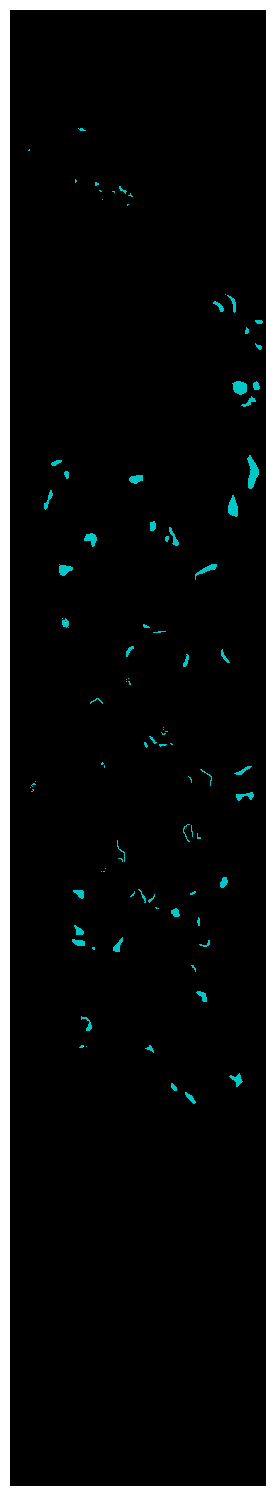

In [106]:
label = np.reshape(label,[H*W])
non_zero_indices = label != 0
map = np.zeros_like(label)
map[non_zero_indices] = labels_dbscan[non_zero_indices]
Draw_Clustering_Map(datasetname,'DBSCAN '+str(eps)+''+str(min_samples),np.reshape(map,[H,W]),'DBSCAN')